# phageParser - Analysis of CRISPR Type for Locus Sizes (R)

Ahmed Hasan (ahmed.hasan@mail.utoronto.ca)

Based off of a notebook by C.K. Yildirim (cemyildirim@fastmail.com)

The latest version of this [Jupyter Notebook](https://jupyter.org) demo is available at http://github.com/phageParser/phageParser

## Introduction
This demo uses the REST API of phageParser running locally to plot the distribution of spacer lengths. In this case, the API is consumed using the `httr` library and the json responses are parsed with `jsonlite` and `dplyr` for gathering basepair length information of spacers.

In [1]:
library(httr)
library(jsonlite)
library(tidyr)
library(ggplot2)
library(dplyr, warn.conflicts = FALSE)
library(magrittr, warn.conflicts = FALSE)
options(stringsAsFactors = FALSE)

In [2]:
apiurl <- 'https://phageparser.herokuapp.com'

# get urls
url_raw <- GET(url = apiurl)
url_json <- rawToChar(url_raw$content) %>%
    fromJSON(flatten = TRUE)

# combine results into single df
url_df <- do.call(what = 'rbind', 
                  args = lapply(url_json, as.data.frame))

# get urls for tables of interest
organism.url <- url_df['organisms',]
casprotein.url <- url_df['casproteins',]

In [3]:
gettable <- function(table_url) {
    pages <- list() # initialize pages
    raw <- GET(url = table_url)
    out <- rawToChar(raw$content) %>%
        fromJSON()
    return(out)
}

organism_init <- gettable(organism.url)
casprotein_init <- gettable(casprotein.url)

In [4]:
# fetching all pages of org table

organism_pages <- list()

for (i in 1:organism_init[[2]]$total_pages) {
    data <- GET(url = paste0(organism.url, '?page=', i,
                            '&include[]=cas_proteins&include[]=loci.spacers'))
    data <- rawToChar(data$content) %>%
        fromJSON(flatten = TRUE)
    message('Retrieved page ', i, ' of ', organism_init[[2]]$total_pages)
    organism_pages[[i]] <- data[[1]] # data[[2]] is metadata for page
}

organism_df <- do.call(what = 'rbind',
                      args = lapply(organism_pages, as.data.frame))

Retrieved page 1 of 7
Retrieved page 2 of 7
Retrieved page 3 of 7
Retrieved page 4 of 7
Retrieved page 5 of 7
Retrieved page 6 of 7
Retrieved page 7 of 7


In [5]:
# fetching all pages of cas protein table

casprotein_pages <- list()

for (i in 1:casprotein_init[[2]]$total_pages) {
    data <- GET(url = paste0(casprotein.url, '?page=', i))
    data <- rawToChar(data$content) %>%
        fromJSON(flatten = TRUE)
    message('Retrieved page ', i, ' of ', casprotein_init[[2]]$total_pages)
    casprotein_pages[[i]] <- data[[1]] # data[[2]] is metadata for page
}

casprotein_df <- do.call(what = 'rbind',
                      args = lapply(casprotein_pages, as.data.frame))

Retrieved page 1 of 1


In [6]:
head(casprotein_df)

id,profileID,function,gene,group,type_specificity
1,cd09634,acquisition_1,cas1,cas1,"CAS-I,CAS-II,CAS-III,CAS-V"
2,cd09636,acquisition_1,cas1,cas1,"CAS-I,CAS-II,CAS-III"
3,cd09718,acquisition_1,cas1,cas1,CAS-I-F
4,cd09719,acquisition_1,cas1,cas1,CAS-I-E
5,cd09720,acquisition_1,cas1,cas1,"CAS-II-A,CAS-II-B,CAS-II-C"
6,cd09721,acquisition_1,cas1,cas1,CAS-I-C


In [7]:
cas3_proteins <- filter(casprotein_df, gene == 'cas3')
cas9_proteins <- filter(casprotein_df, gene == 'cas9')
cas10_proteins <- filter(casprotein_df, gene == 'cas10')

In [8]:
organism_types <- organism_df

checkproteins <- function(proteins, reference){
    # helper function for check_type() - checks type membership
  checklist <- lapply(proteins, function(i) i %in% reference)
  return(TRUE %in% checklist)
}

check_type <- function(cas_proteins) {
    # uses checkproteins to assign crispr types
  cas3 <- cas3_proteins$id
  cas9 <- cas9_proteins$id
  cas10 <- cas10_proteins$id
  
  cas_proteins <- cas_proteins[[1]] # packed in list
  ret_type <- list(c())
  if (checkproteins(cas_proteins, cas3)) {
    ret_type[[1]] %<>% c('Type I')
  }
  if (checkproteins(cas_proteins, cas9)) {
    ret_type[[1]] %<>% c('Type II')
  }
  if (checkproteins(cas_proteins, cas10)) {
    ret_type[[1]] %<>% c('Type III')
  }
  return(ret_type)
}
                      
# run above functions on all organisms to sort them into CRISPR types

organism_types %<>%
  group_by(id) %>%
  mutate(type = check_type(cas_proteins)) %>%
  ungroup()

In [9]:
# check for single spacer organisms in our new df
# need to unpack the loci column in organism_types

spacer_check <- function(df) {
  df <- df[[1]] %>% # unpack data frame
    as.data.frame()
  spacers <- df$spacers[[1]] # unpack spacers df
  if (is.null(spacers)) { # no loci - this is the case for a few orgs
    out <- NA
  } else if (nrow(spacers) > 0) {
      spacer_count <- dim(spacers)[1]
      if (spacer_count == 1) {
        out <- 'single'
      } else if (spacer_count > 1) {
        out <- 'multi'
      } else {
        out <- NA
      } 
    }
  return(out)
}

# grouped mutate is being unfriendly - try the old fashioned way
organism_types$spacer_count <- ''
for (i in 1:dim(organism_types)[1]) {
  organism_types$spacer_count[i] <- spacer_check(organism_types$loci[i])
}

In [10]:
# calculate how many single + multi spacer orgs were assigned CRISPR types

check_active <- function(df){
  df <- unlist(df)
  out <- ifelse(is.null(df), 'False', 'True')
  return(out)
}

iscrispr_single_spacer <- organism_types %>% 
  filter(spacer_count == 'single') %>% 
  group_by(id) %>% 
  mutate(active = check_active(type)) %>% 
  ungroup() %>% 
  group_by(active) %>% 
  summarise(count = n())

paste0('Active CRISPR system percentage for organisms with single spacer is ', 
      iscrispr_single_spacer[2,2] * 100 / sum(iscrispr_single_spacer$count), '%')
  
iscrispr_multi_spacer <- organism_types %>% 
  filter(spacer_count == 'multi') %>% 
  group_by(id) %>% 
  mutate(active = check_active(type)) %>% 
  ungroup() %>% 
  group_by(active) %>% 
  summarise(count = n())

paste0('Active CRISPR system percentage for organisms with multiple spacers is ', 
       iscrispr_multi_spacer[2,2] * 100 / sum(iscrispr_multi_spacer$count), '%')

[1] "Active CRISPR system percentage for organisms with single spacer is 97.910447761194%"

[1] "Active CRISPR system percentage for organisms with multiple spacers is 96.9973890339426%"

In [11]:
# histogram of spacer length across all spacers in dataset

all_loci <- organism_types$loci

get_spacer_lengths <- function(loci) {
    # function needed to pull out and unlist spacers from indiv records
  if (is.null(unlist(loci))) {
    lengths <- NA
  } else {
    spacerdf <- loci %>% 
      as.data.frame() %>% 
      select(spacers)
    lengths <- c()
    for (i in 1:nrow(spacerdf)) {
      spacers <- spacerdf[i,] %>% as.data.frame()
      l <- spacers$length
      lengths %<>% c(l)
    }
  }
  return(lengths)
}

# this is a clumsy method... grows a vector of lengths
lengths <- c()
for (i in 1:length(all_loci)) {
  lengths <- c(lengths, get_spacer_lengths(all_loci[i]))
}

lengthsdf <- as.data.frame(lengths)

In [12]:
head(lengthsdf)

lengths
30
30
30
30
30
30


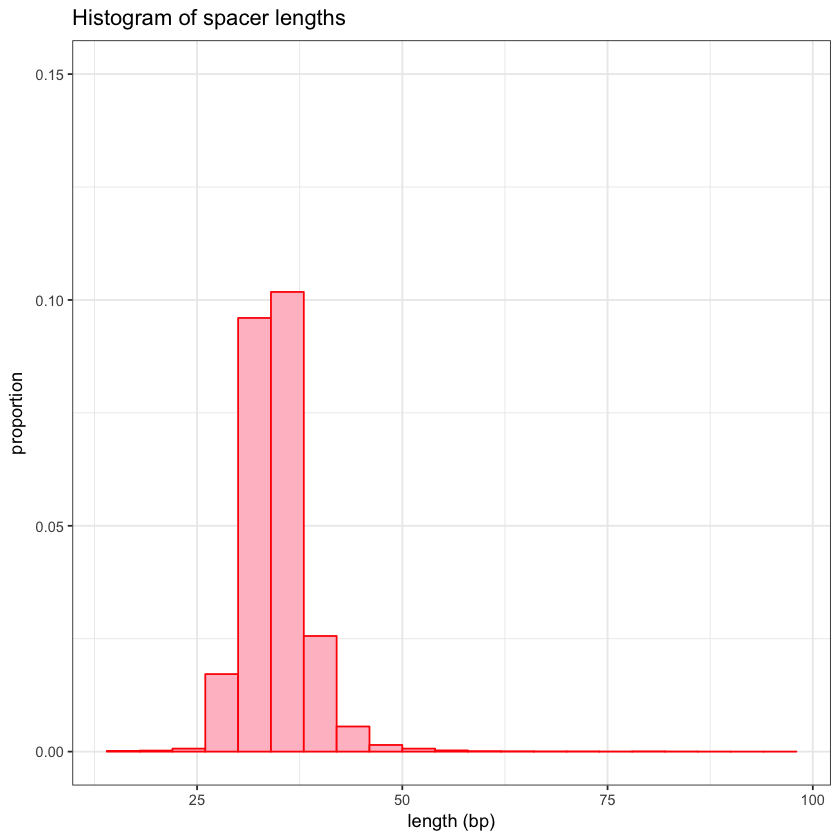

In [13]:
spacer_length_dist <- ggplot(lengthsdf, aes(x = lengths, y = ..density..)) + 
    geom_histogram(col = 'red', fill = 'pink', binwidth = 4, na.rm = TRUE) +
    theme_bw() +
    ggtitle('Histogram of spacer lengths') +
    xlab('length (bp)') +
    ylab('proportion') +
    coord_cartesian(y = c(0, 0.15))

spacer_length_dist

In [14]:
# histogram of spacer counts across all organisms in dataset

all_loci <- organism_types$loci

get_spacer_count <- function(loci) {
  if (is.null(unlist(loci))) {
    n_spacers <- NA
  } else {
    spacerdf <- loci %>% 
      as.data.frame() %>% 
      select(spacers)
    n_spacers <- nrow(spacerdf)
  }
  return(n_spacers)
}

# still clumsy
s_count <- c()
for (i in 1:length(all_loci)) {
  s_count <- c(s_count, get_spacer_count(all_loci[i]))
}
s_countdf <- as.data.frame(s_count)

[1] 2.604001

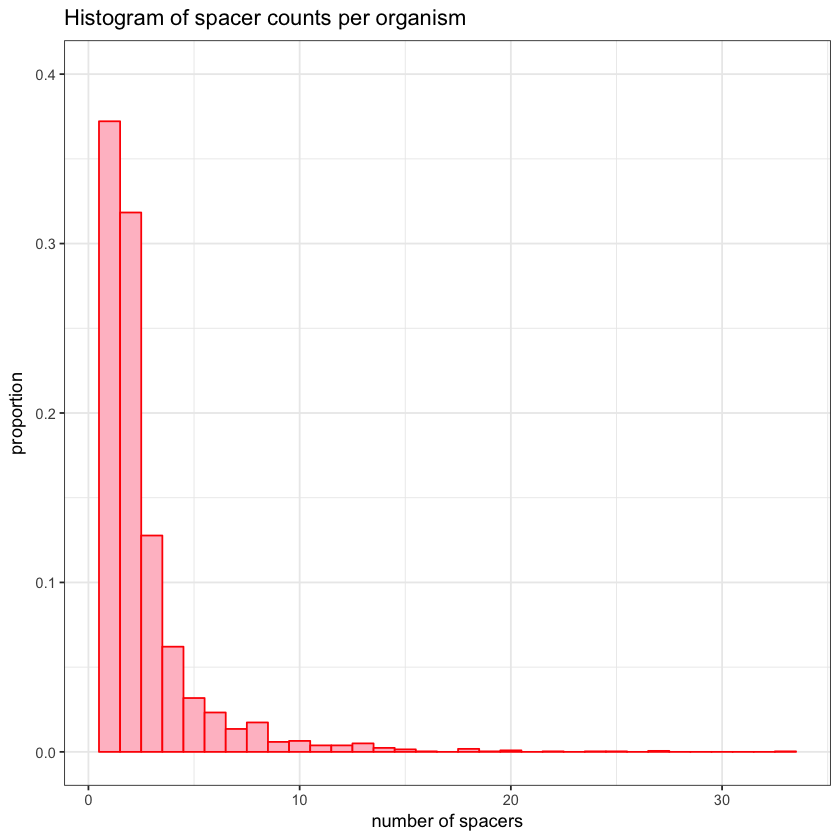

In [15]:
s_count_plot <- ggplot(s_countdf, aes(x = s_count, y = ..density..)) + 
    geom_histogram(col = 'red', fill = 'pink', binwidth = 1, na.rm = TRUE) +
    theme_bw() +
    ggtitle('Histogram of spacer counts per organism') +
    xlab('number of spacers') +
    ylab('proportion') +
    coord_cartesian(y = c(0, 0.4))

mean(s_countdf$s_count, na.rm = TRUE)
s_count_plot